# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [2]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [3]:
import os
from pickletools import uint8
from pyexpat.errors import XML_ERROR_TAG_MISMATCH
from typing import final

import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations                
import seaborn as sns                                                                            # Importing seaborn to plot graphs

# Tensorflow modules
import tensorflow as tf
from imblearn import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator                            # Importing the ImageDataGenerator for data augmentation deprecated
from tensorflow.data import Dataset                                                              # Importing Dataset for image transformation/augmentation
from tensorflow.image import (resize, 
                              resize_with_crop_or_pad,
                              rot90, 
                              random_flip_left_right)
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import (Dense,
                                     Dropout,
                                     Flatten,
                                     Conv2D,
                                     MaxPooling2D,
                                     BatchNormalization,
                                     Input)                                                      # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from tensorflow.keras.utils import to_categorical                                                # Importing function used to convert class vectors (integers) into
                                                                                                 # binary class matrix (one-hot encoding)
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
import cv2                                                                                       # Importing openCV for image processing
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
print(f"{tf.__version__}")
print(f"{tf.keras.__version__}")

2.15.0
3.4.1


## Loading the dataset

In [5]:
# Uncomment and run the below code if you are using google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# Load the image file of dataset
images = np.load('images.npy')      # Complete the code to read the dataset

# Load the labels file of dataset
labels = pd.read_csv('Labels.csv')  # Complete the code to read the dataset

## Data Overview

### Understand the shape of the dataset

In [7]:
images.shape

(4750, 128, 128, 3)

In [8]:
labels.shape

(4750, 1)

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [9]:
labels.head()

Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill

In [10]:
labels.nunique()

Label    12
dtype: int64

In [11]:
labels_list = labels['Label'].unique().tolist()
print(labels_list)

['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse', 'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers', 'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass', 'Loose Silky-bent']


In [12]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

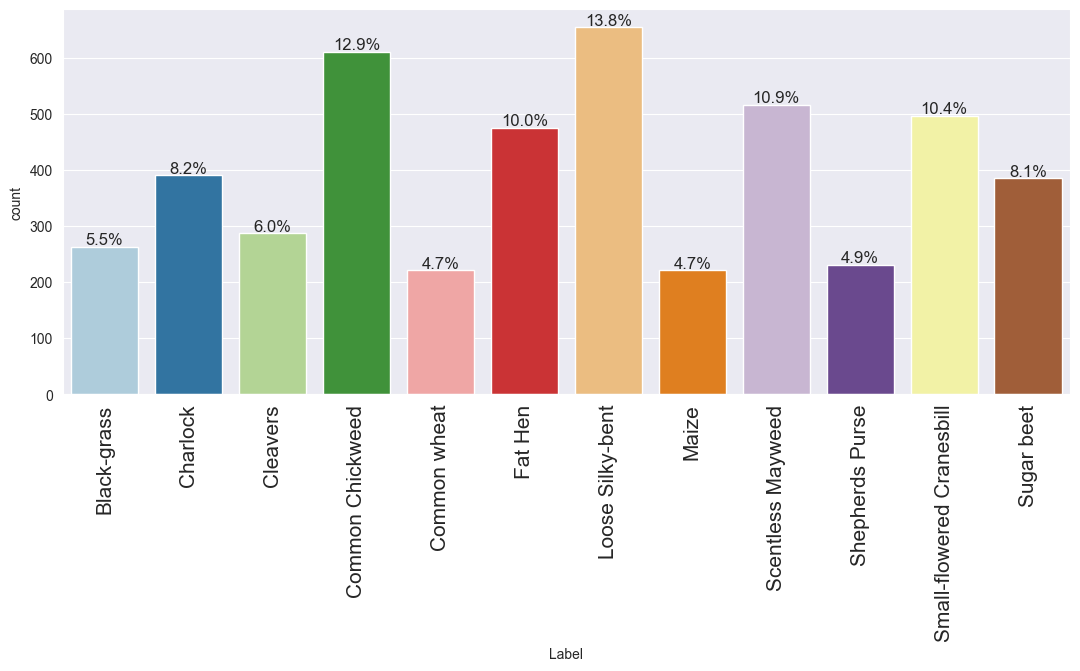

In [13]:
labeled_barplot(labels, 'Label', perc=True)

In [14]:
print(labels['Label'].iloc[10])

Small-flowered Cranesbill


In [15]:
import random

def plot_random_images(number=10, image_array=images, label_array=labels, random=True, channels='BGR'):
    '''
    plot images
    :param number: number of images to plot 
    :param image_array: image array in BGR format
    :param label_array: array of labels
    :param random: select images randomly (default) or take first 10 (or number) images
    :return: none
    '''
    # Plot multiple images as subplots
    fig, axes = plt.subplots(number // 5 + (number % 5 > 0), 5, figsize=(20, 20))

    for i in range(number):
        if random:
            r1 = random.randint(0, number)
        else:
            r1 = i
        ax = axes[i // 5, i % 5]
        if channels == 'BGR':
            ax.imshow(cv2.cvtColor(image_array[r1], cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(image_array[r1])
        ax.set_title(label_array['Label'].iloc[r1])

    plt.tight_layout()
    plt.show()
    

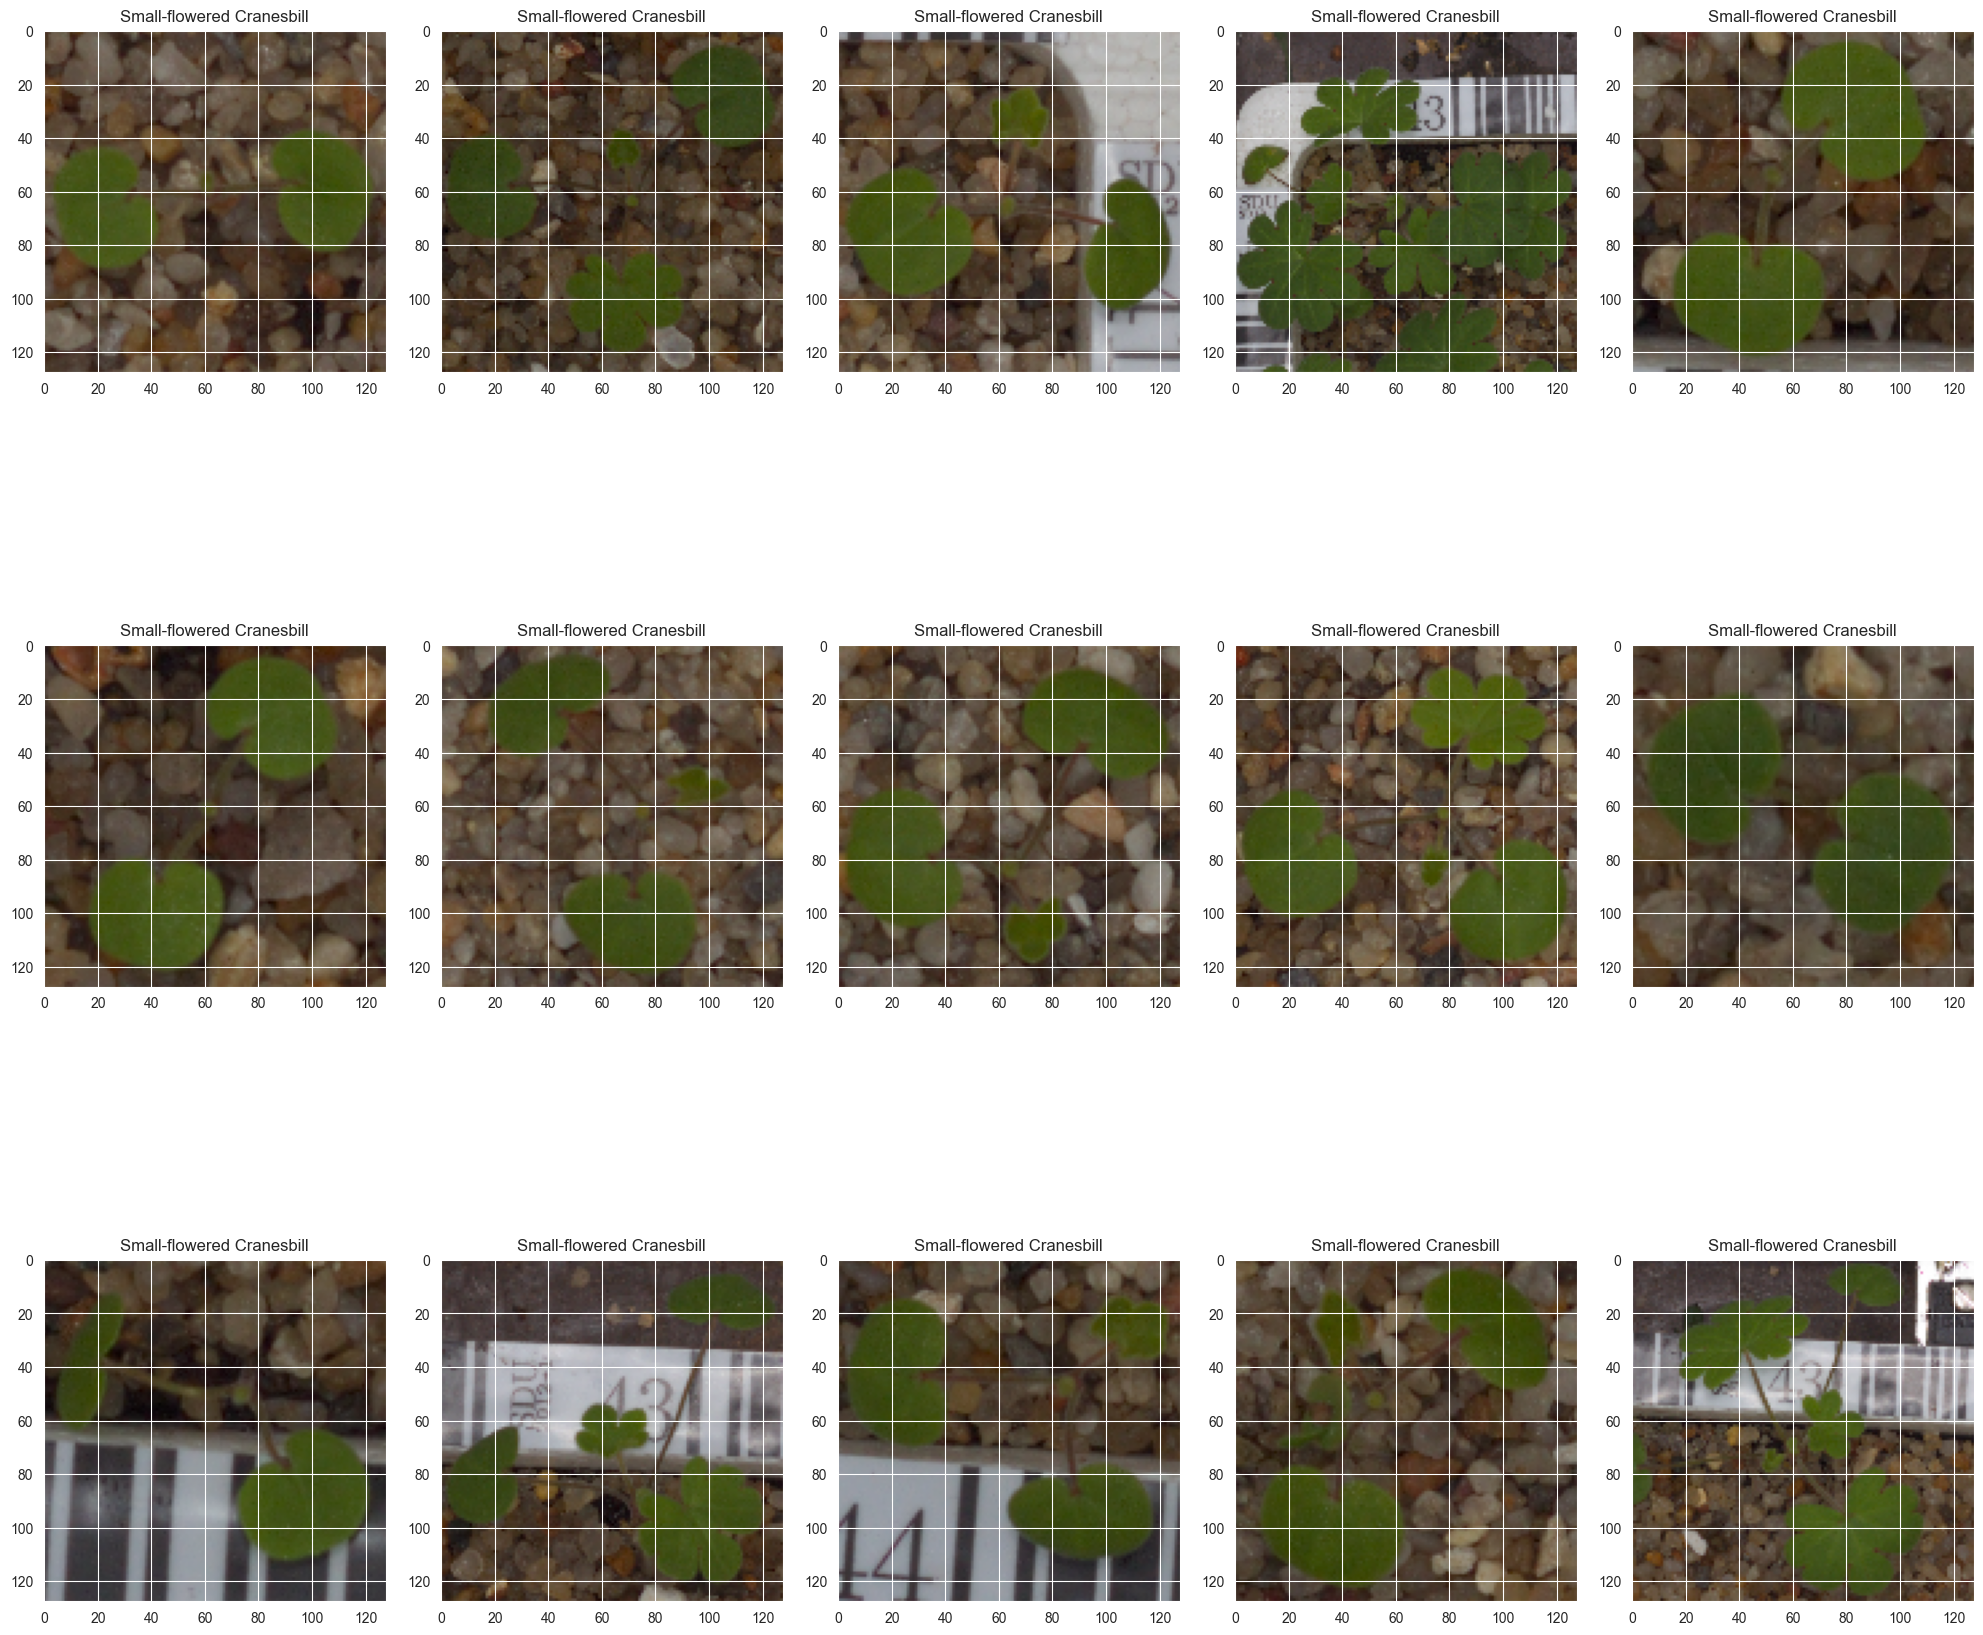

In [16]:
plot_random_images(15, images, labels, random=False)

### Observation
As we can see the dataset is not balanced, we will take care of this below in the model performance improvement section, as well as when we will fit the model.

There is 12 categories in this data set.

## Data Pre-Processing

In [17]:
for i in range(len(images)):
    images[i] = cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0)

### Convert the BGR images to RGB images.

We convert the images in RGB as we might want to use pre-trained model like VGG16

In [18]:
images_bgr = images.copy()
for i in range(len(images)):
    images_bgr[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [19]:
images_bgr.shape

(4750, 128, 128, 3)

In [20]:
images_bgr_resized = np.empty((4750, 64, 64, 3), dtype=np.uint8)
for i in range(len(images_bgr)):
    images_bgr_resized[i] = cv2.resize(images_bgr[i], (64, 64), interpolation=cv2.INTER_LINEAR)
    images_bgr_resized[i] = cv2.GaussianBlur(images_bgr_resized[i], ksize =(3,3),sigmaX =  0)
    
print(images_bgr_resized.shape)

(4750, 64, 64, 3)


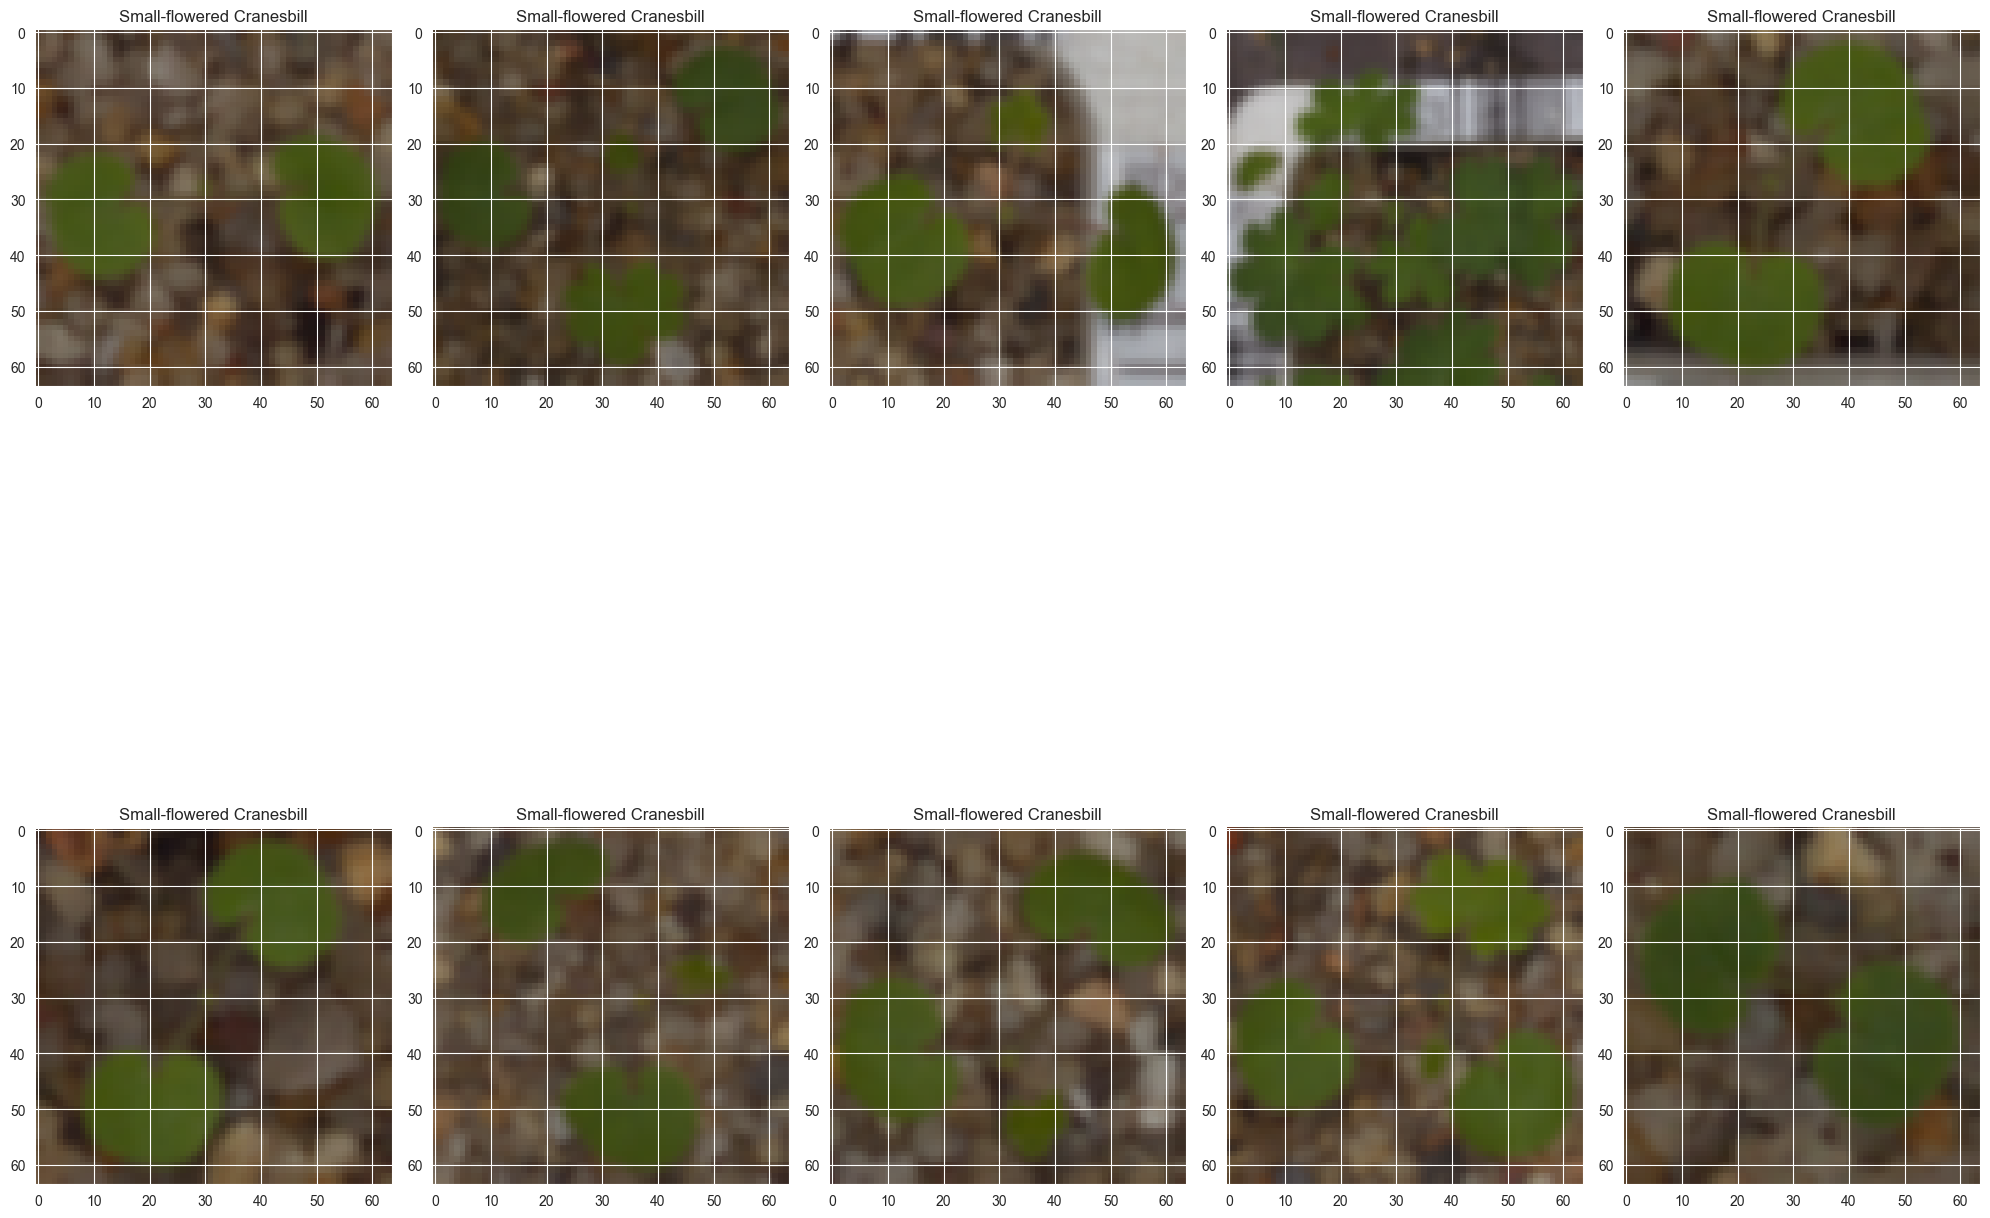

In [21]:
plot_random_images(10, images_bgr_resized, labels, random=False, channels='RGB')

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

### Encode the target labels


In [22]:
num_classes = labels['Label'].nunique()
enc = LabelBinarizer()
y = enc.fit_transform(labels['Label'])

print(y[0])

[0 0 0 0 0 0 0 0 0 0 1 0]


### Split the dataset


In [23]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test
X_temp, X_test, y_temp, y_test = train_test_split(
    images_bgr_resized, y, test_size=0.2, random_state=42, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2850, 64, 64, 3) (950, 64, 64, 3) (950, 64, 64, 3)
(2850, 12) (950, 12) (950, 12)


### Data Normalization

In [24]:

def data_normalization(data):
    '''
    Normalize the data
    :param data: the data to be normalized
    :return: the normalized data
    '''
    return data.astype('float32') / 255.0

In [25]:
X_test = data_normalization(X_test)
X_val = data_normalization(X_val)
X_train = data_normalization(X_train)

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [26]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

**Early stop callback**

In [27]:
# stop sooner if no more improvement is made
from tensorflow.keras.callbacks import EarlyStopping
es_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=20,
    mode='max',
)

**Calculate the class weights for an imbalanced dataset**

In [28]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(np.argmax(y_train, axis=1)),
                                     y=np.argmax(y_train, axis=1)
                                     )
cw_dict = {}
for i in range(class_weights.shape[0]):
    cw_dict[i] = class_weights[i]

cw_dict

{0: 1.5127388535031847,
 1: 1.014957264957265,
 2: 1.3888888888888888,
 3: 0.6471389645776566,
 4: 1.7857142857142858,
 5: 0.8333333333333334,
 6: 0.6058673469387755,
 7: 1.7857142857142858,
 8: 0.7661290322580645,
 9: 1.70863309352518,
 10: 0.7969798657718121,
 11: 1.0281385281385282}

## Data Augmentation
Remember, **data augmentation should not be used in the validation/test data set**.

In [29]:
# Custom function to randomly flip images horizontally
def random_flip(image):
    '''
    Randomly flips an image horizontally
    :param image: image to flip
    :return: flipped image
    '''
    return random_flip_left_right(image)

# Custom function to randomly rotate images
def random_rotate(image, max_angle=10):
    '''
    Randomly rotates an image
    :param image: image to rotate
    :param max_angle: range of the random rotation
    :return: rotated image
    '''
    angle = tf.random.uniform([], -max_angle, max_angle, dtype=tf.float32)
    return rot90(image, k=tf.cast(angle // 90, tf.int32))

# Custom function to randomly zoom images
def random_zoom(image, zoom_range=(1, 1)):
    '''
    Randomly zooms an image
    :param image: image to zoom
    :param zoom_range: zoomed range
    :return:  zoomed image range
    '''
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])
    img_shape = tf.shape(image)
    height, width = img_shape[0], img_shape[1]

    new_height = tf.cast(zoom_factor * tf.cast(height, tf.float32), tf.int32)
    new_width = tf.cast(zoom_factor * tf.cast(width, tf.float32), tf.int32)

    # Ensure new_height and new_width are not zero
    new_height = tf.maximum(1, new_height) # Changed from 0 to 1
    new_width = tf.maximum(1, new_width) # Changed from 0 to 1
    
    # Resize and then crop back to original size
    image_resized = resize(image, [new_height, new_width])
    image_cropped = resize_with_crop_or_pad(image_resized, height, width)
    return image_cropped

# Custome function to randomly zoom images using OpenCV as still have troubles with the Terraflow APIs
def random_zoom_cv(image, zoom_range=(0.9, 1.1)):
    '''
    Randomly zooms an image using OpenCV
    :param image: image to zoom
    :param zoom_range: zoomed range
    :return: zoomed image
    '''
    zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
    img_shape = image.shape
    height, width = img_shape[0], img_shape[1]

    new_height = int(zoom_factor * height)
    new_width = int(zoom_factor * width)

    # Ensure new_height and new_width are not zero
    new_height = max(1, new_height)
    new_width = max(1, new_width)


    # Use tf.numpy_function with explicit output shape
    image_resized = tf.numpy_function(lambda x: cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_LINEAR).astype(np.float64), [image], tf.float64)
    # Set the shape of the resized image
    image_resized.set_shape(image.shape)
    # no interpolation we want to crop the image to the original size only
    image_cropped = tf.numpy_function(lambda x: cv2.resize(x, (width, height)).astype(np.float64), [image_resized], tf.float64)
    # Set the shape of the cropped image
    image_cropped.set_shape(image.shape)

    return image_cropped

# Custom function to randomly change contrast
def random_contrast(image, contrast_range=(0.8, 1.2)):
    '''
    Adjust the contrast of the image
    :param image: image to contrast
    :param contrast_range: contrast range
    :return: constrasted image
    '''
    return tf.image.random_contrast(image, contrast_range[0], contrast_range[1])

# Combine all augmentation functions into one function
def augment_image(image):
    '''
    Apply a random combination of the following augmentations to the image:
    :param image: image to augment
    :return: augmented image
    '''
    image = random_flip(image)
    image = random_rotate(image)
    image = random_zoom_cv(image)
    image = random_contrast(image)
    return image

In [30]:
# Function to create multiple augmented copies of an image
def create_augmented_copies(image, label, num_copies=3):
    # Create a dataset of `num_copies` duplicate images
    duplicated_images = tf.data.Dataset.from_tensors((image, label)).repeat(num_copies)
    # Apply augmentation to each duplicate
    augmented_images = duplicated_images.map(lambda x, y: (augment_image(x), y))
    return augmented_images

# Specify how many augmented images per original image
num_augmented_images = 3

# Convert the NumPy arrays to TensorFlow Dataset
train_dataset = Dataset.from_tensor_slices((X_train, y_train))

# Apply augmentation only to the training dataset
# train_dataset = train_dataset.map(lambda x, y: (augment_image(x), y))

# Use flat_map to generate multiple augmented versions of each image
train_dataset = train_dataset.flat_map(lambda x, y: create_augmented_copies(x, y, num_copies=num_augmented_images))


# Shuffle, batch, and prefetch the dataset for better performance
batch_size = 32
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Model Building

#### Model preparation

In [31]:
image_def = X_train[0].shape
image_height = image_def[0]
image_width = image_def[1]
num_channels = image_def[2]
print(f'Image size: {image_height} x {image_width} x {num_channels}')

Image size: 64 x 64 x 3


In [32]:
print(f'Number of classes: {num_classes}')

Number of classes: 12


In [33]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Model 0
Model 0 doesn't use any image augmentation

In [34]:
backend.clear_session()

In [35]:
model_0 = Sequential([
    Input(shape=(image_height, image_width, num_channels)),
    Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax',kernel_initializer='he_normal')
])

In [36]:
# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model_0.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Generating the summary of the model
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,244 (2.47 MB)

 Trainable params: 647,116 (2.47 MB)

 Non-trainable params: 128 (512.00 B)

In [37]:
history_model_0 = model_0.fit(
    x=X_train,
    y=y_train,
    epochs=70,
    validation_data=(X_val, y_val),
    class_weight=cw_dict,
    callbacks=[es_cb,learning_rate_reduction]
)

Epoch 1/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2631 - loss: 2.3265 - val_accuracy: 0.1968 - val_loss: 2.1434 - learning_rate: 0.0010
Epoch 2/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5838 - loss: 1.2128 - val_accuracy: 0.1284 - val_loss: 2.8375 - learning_rate: 0.0010
Epoch 3/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6936 - loss: 0.8234 - val_accuracy: 0.2421 - val_loss: 2.6886 - learning_rate: 0.0010
Epoch 4/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7982 - loss: 0.5784 - val_accuracy: 0.2547 - val_loss: 4.0498 - learning_rate: 0.0010
Epoch 5/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8773 - loss: 0.3832 - val_accuracy: 0.2989 - val_loss: 6.1245 - learning_rate: 0.0010
Epoch 6/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9063 - loss: 0.2874 - val_accuracy: 0.2916 - val_loss: 5.6403 - learning_rate: 0.0010
Epoch 7/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9397 - loss: 0.1882 - val_acc

### Visualizing the prediction model0


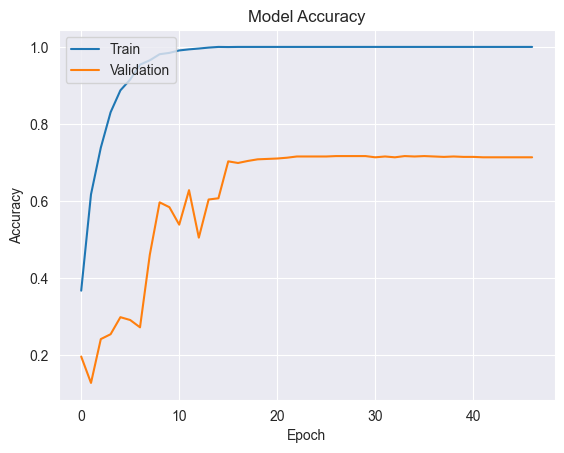

In [38]:
plt.plot(history_model_0.history['accuracy'])
plt.plot(history_model_0.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [103]:
# Here we would get the output as probablities for each category
y_pred_val=model_0.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [40]:
def plot_confusion_matrix(y_pred, y_test_encoded, classes,):
    # Obtaining the categorical values from y_test_encoded and y_pred
    y_pred_arg=np.argmax(y_pred,axis=1)
    y_test_arg=np.argmax(y_test_encoded,axis=1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax,
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.show()

In [104]:
model_0_evaluation = model_0.evaluate(X_val,(y_val))
print(model_0_evaluation)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7072 - loss: 1.6757
[1.5240949392318726, 0.7168421149253845]


In [42]:
y_pred_model_0_val = model_0.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


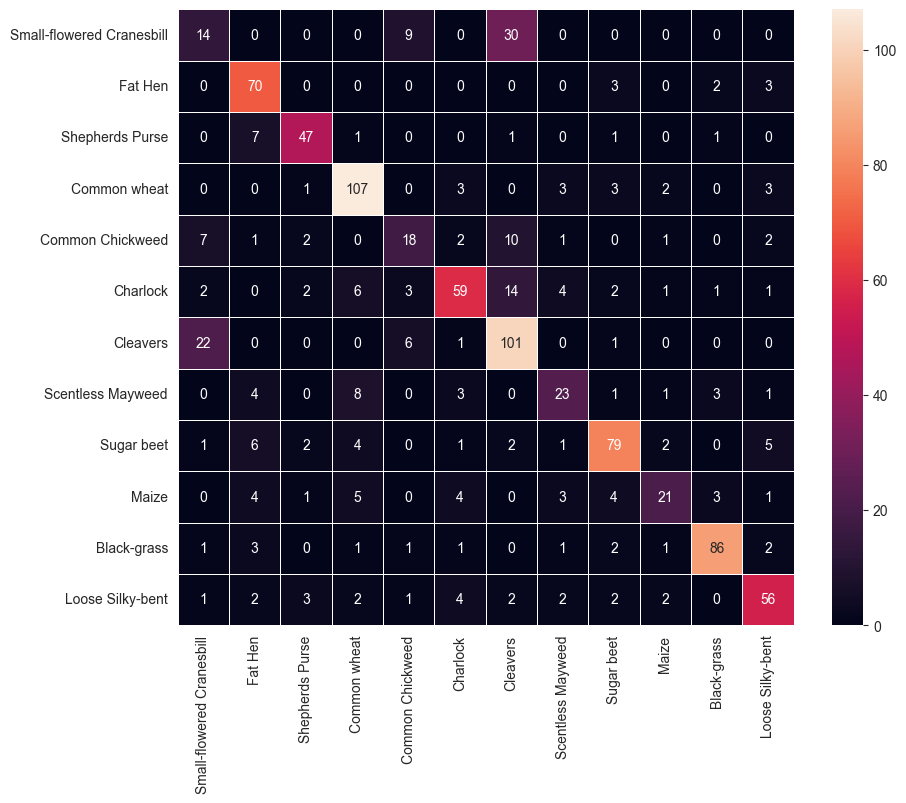

In [43]:
plot_confusion_matrix(y_pred_model_0_val, y_val, labels_list)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_model_0_val, axis=1), target_names=labels_list))

                           precision    recall  f1-score   support

Small-flowered Cranesbill       0.29      0.26      0.28        53
                  Fat Hen       0.72      0.90      0.80        78
          Shepherds Purse       0.81      0.81      0.81        58
             Common wheat       0.80      0.88      0.84       122
         Common Chickweed       0.47      0.41      0.44        44
                 Charlock       0.76      0.62      0.68        95
                 Cleavers       0.63      0.77      0.69       131
        Scentless Mayweed       0.61      0.52      0.56        44
               Sugar beet       0.81      0.77      0.79       103
                    Maize       0.68      0.46      0.55        46
              Black-grass       0.90      0.87      0.88        99
         Loose Silky-bent       0.76      0.73      0.74        77

                 accuracy                           0.72       950
                macro avg       0.69      0.67      0.67    

### Model 1
Model 1 is the same architecture as model 0 with image augmentation

In [45]:
backend.clear_session()

In [46]:

model_1 = Sequential([
    Input(shape=(image_height, image_width, num_channels)),
    Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax',kernel_initializer='he_normal')
])

In [47]:
# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Generating the summary of the model
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,244 (2.47 MB)

 Trainable params: 647,116 (2.47 MB)

 Non-trainable params: 128 (512.00 B)

In [48]:
history_model_1 = model_1.fit(
    train_dataset,
    epochs=70,
    validation_data=(X_val, y_val),
    class_weight=cw_dict,
    callbacks=[es_cb,learning_rate_reduction]
)

Epoch 1/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3863 - loss: 1.9013 - val_accuracy: 0.3632 - val_loss: 2.2911 - learning_rate: 0.0010
Epoch 2/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6268 - loss: 1.1009 - val_accuracy: 0.4116 - val_loss: 2.3712 - learning_rate: 0.0010
Epoch 3/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6929 - loss: 0.8899 - val_accuracy: 0.6684 - val_loss: 1.1497 - learning_rate: 0.0010
Epoch 4/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7702 - loss: 0.6755 - val_accuracy: 0.5600 - val_loss: 1.5805 - learning_rate: 0.0010
Epoch 5/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8085 - loss: 0.5337 - val_accuracy: 0.6916 - val_loss: 1.0690 - learning_rate: 0.0010
Epoch 6/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8281 - loss: 0.4579 - val_accuracy: 0.6842 - val_loss: 1.0936 - learning_rate: 0.0010
Epoch 7/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8769 - l

### Visualizing the prediction model1

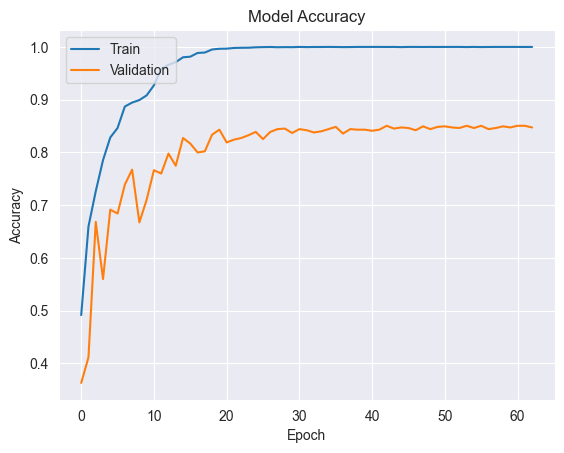

In [49]:
plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [105]:
# Here we would get the output as probablities for each category
y_pred_val=model_1.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [106]:
model_1_evaluation = model_1.evaluate(X_val,(y_val))
print(model_1_evaluation)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8436 - loss: 0.8569
[0.7309905290603638, 0.8505263328552246]


In [52]:
y_pred_model_1_val = model_1.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


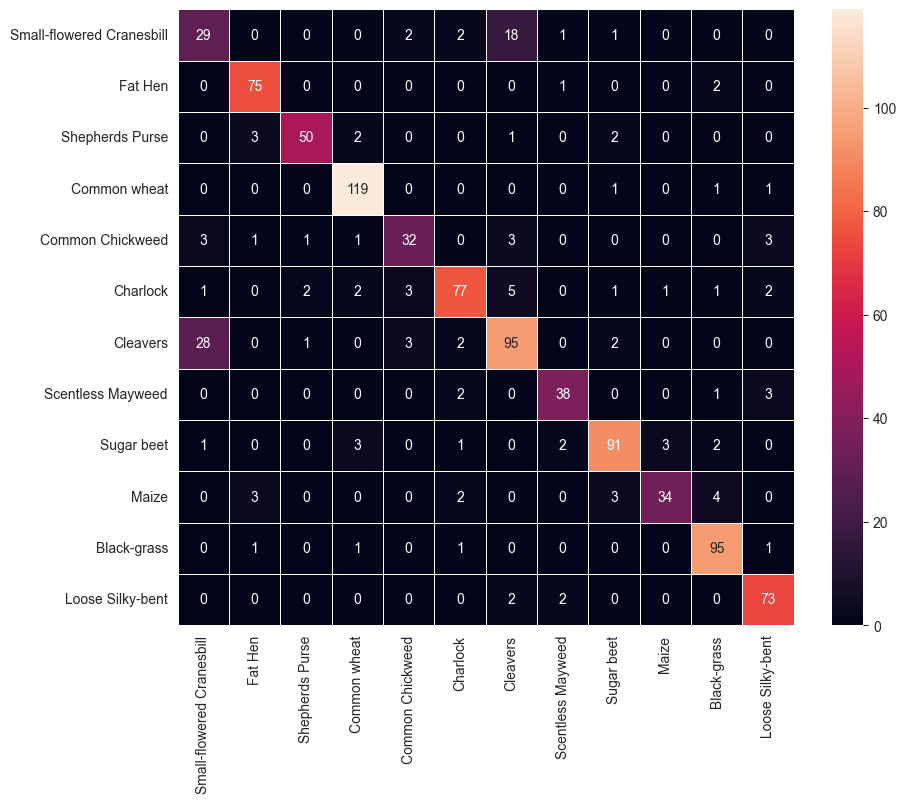

In [53]:
plot_confusion_matrix(y_pred_model_1_val, y_val, labels_list)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_model_1_val, axis=1), target_names=labels_list))

                           precision    recall  f1-score   support

Small-flowered Cranesbill       0.47      0.55      0.50        53
                  Fat Hen       0.90      0.96      0.93        78
          Shepherds Purse       0.93      0.86      0.89        58
             Common wheat       0.93      0.98      0.95       122
         Common Chickweed       0.80      0.73      0.76        44
                 Charlock       0.89      0.81      0.85        95
                 Cleavers       0.77      0.73      0.75       131
        Scentless Mayweed       0.86      0.86      0.86        44
               Sugar beet       0.90      0.88      0.89       103
                    Maize       0.89      0.74      0.81        46
              Black-grass       0.90      0.96      0.93        99
         Loose Silky-bent       0.88      0.95      0.91        77

                 accuracy                           0.85       950
                macro avg       0.84      0.83      0.84    

### Model 2 (using VGG19)


In [55]:
backend.clear_session()

In [56]:
from tensorflow.keras.applications import VGG19

vgg_base_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_height, image_width, num_channels))
vgg_base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
for layer in vgg_base_model.layers:
    layer.trainable = False

In [58]:
model_2 = Sequential([
    Input(shape=(image_height, image_width, num_channels)),
    vgg_base_model,
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(num_classes, activation='softmax')
])

In [59]:
# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Generating the summary of the model
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 2, 2, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,297,740 (77.43 MB)

 Trainable params: 272,332 (1.04 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [60]:
history_model_2 = model_2.fit(
    train_dataset,
    epochs=70,
    validation_data=(X_val, y_val),
    class_weight=cw_dict,
    callbacks=[es_cb,learning_rate_reduction]
)

Epoch 1/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 1190s 4s/step - accuracy: 0.3551 - loss: 1.8719 - val_accuracy: 0.4789 - val_loss: 1.5449 - learning_rate: 0.0010
Epoch 2/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 80s 299ms/step - accuracy: 0.5328 - loss: 1.2952 - val_accuracy: 0.4642 - val_loss: 1.5564 - learning_rate: 0.0010
Epoch 3/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 86s 320ms/step - accuracy: 0.6168 - loss: 1.0721 - val_accuracy: 0.5211 - val_loss: 1.5237 - learning_rate: 0.0010
Epoch 4/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 91s 338ms/step - accuracy: 0.6484 - loss: 0.9795 - val_accuracy: 0.4926 - val_loss: 1.6112 - learning_rate: 0.0010
Epoch 5/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 90s 334ms/step - accuracy: 0.6760 - loss: 0.8861 - val_accuracy: 0.5432 - val_loss: 1.4621 - learning_rate: 0.0010
Epoch 6/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 99s 369ms/step - accuracy: 0.7107 - loss: 0.8213 - val_accuracy: 0.5558 - val_loss: 1.5551 - learning_rate: 0.0010
Epoch 7/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 100s 370ms/step - accuracy: 0.7

### Visualizing the prediction model2

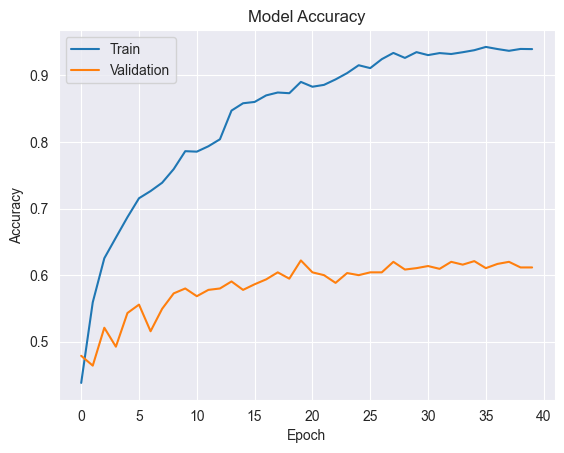

In [61]:
plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [107]:
model_2_evaluation = model_2.evaluate(X_val, (y_val))
print(model_2_evaluation)

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.6000 - loss: 1.7613
[1.7789973020553589, 0.6042105555534363]


In [108]:
y_pred_model_2_val = model_2.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step


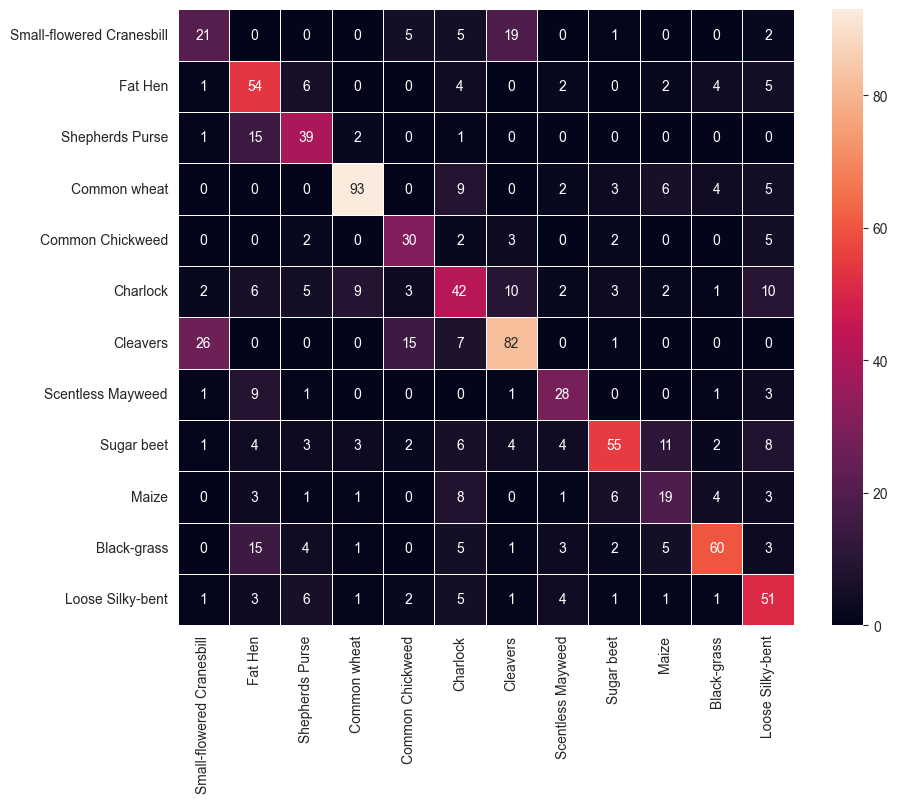

In [64]:
plot_confusion_matrix(y_pred_model_2_val, y_val, labels_list)

In [65]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_model_2_val, axis=1), target_names=labels_list))

                           precision    recall  f1-score   support

Small-flowered Cranesbill       0.39      0.40      0.39        53
                  Fat Hen       0.50      0.69      0.58        78
          Shepherds Purse       0.58      0.67      0.62        58
             Common wheat       0.85      0.76      0.80       122
         Common Chickweed       0.53      0.68      0.59        44
                 Charlock       0.45      0.44      0.44        95
                 Cleavers       0.68      0.63      0.65       131
        Scentless Mayweed       0.61      0.64      0.62        44
               Sugar beet       0.74      0.53      0.62       103
                    Maize       0.41      0.41      0.41        46
              Black-grass       0.78      0.61      0.68        99
         Loose Silky-bent       0.54      0.66      0.59        77

                 accuracy                           0.60       950
                macro avg       0.59      0.59      0.58    

### Model 3

In [66]:
backend.clear_session()

In [67]:
model_3 = Sequential([
    Input(shape=(image_height, image_width, num_channels)),
    Conv2D(64, (3, 3), padding='same', activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu',kernel_initializer='he_normal'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu',kernel_initializer='he_normal'),
    # Dropout(0.3),
    Dense(64, activation='relu',kernel_initializer='he_normal'),
    Dense(num_classes, activation='softmax')
])

In [68]:
# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Generating the summary of the model
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,652 (1.25 MB)

 Trainable params: 328,588 (1.25 MB)

 Non-trainable params: 64 (256.00 B)

In [69]:
history_model_3 = model_3.fit(
    train_dataset,
    epochs=70,
    validation_data=(X_val, y_val),
    class_weight=cw_dict,
    callbacks=[es_cb, learning_rate_reduction]
)

Epoch 1/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.2462 - loss: 2.1167 - val_accuracy: 0.2916 - val_loss: 2.0988 - learning_rate: 0.0010
Epoch 2/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5896 - loss: 1.1625 - val_accuracy: 0.6389 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 3/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7092 - loss: 0.8040 - val_accuracy: 0.7358 - val_loss: 0.7636 - learning_rate: 0.0010
Epoch 4/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.7525 - loss: 0.6576 - val_accuracy: 0.6463 - val_loss: 1.0843 - learning_rate: 0.0010
Epoch 5/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8056 - loss: 0.5407 - val_accuracy: 0.7421 - val_loss: 0.7363 - learning_rate: 0.0010
Epoch 6/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8417 - loss: 0.4304 - val_accuracy: 0.7768 - val_loss: 0.7012 - learning_rate: 0.0010
Epoch 7/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8537 - l

### Visualizing the prediction model3

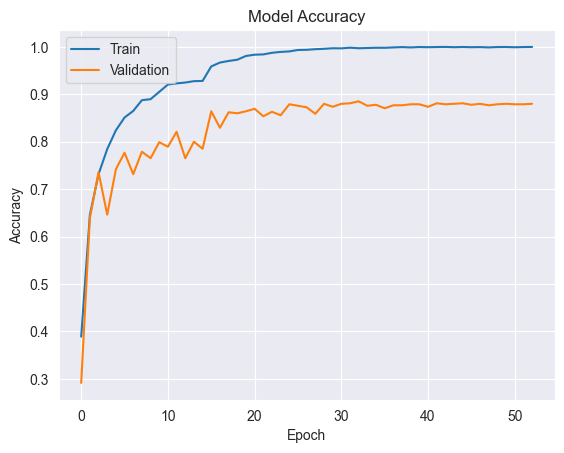

In [70]:
plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [109]:
model_3_evaluation = model_3.evaluate(X_val, (y_val))
print(model_3_evaluation)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8773 - loss: 0.7773
[0.6302897930145264, 0.8852631449699402]


In [110]:
y_pred_model_3_val = model_3.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


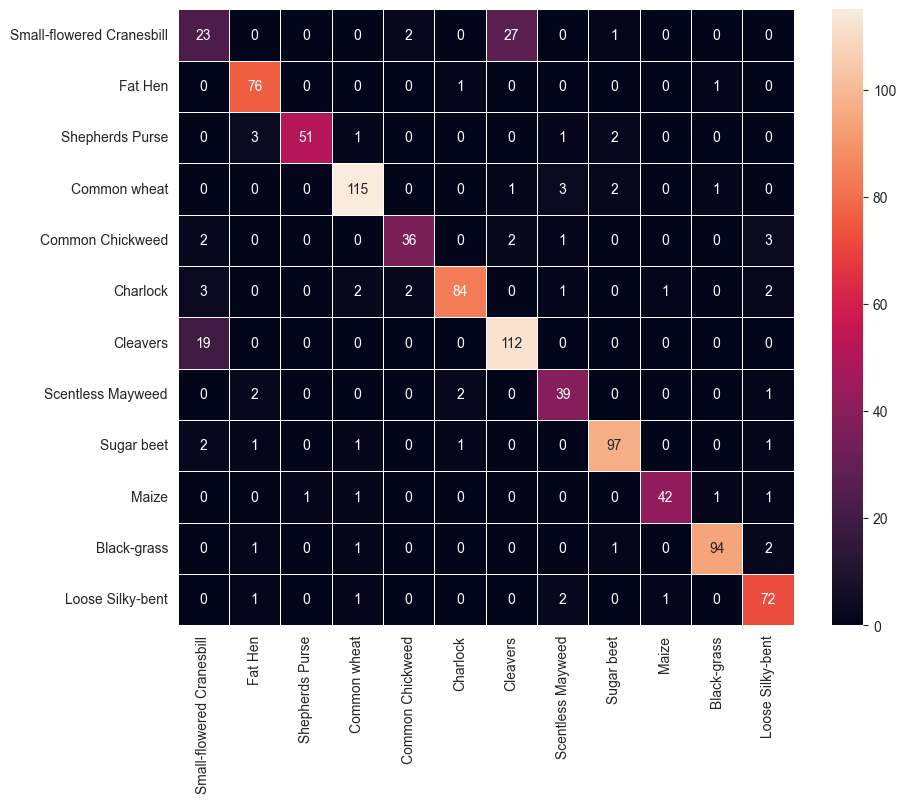

In [73]:
plot_confusion_matrix(y_pred_model_3_val, y_val, labels_list)

In [74]:
print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_model_3_val, axis=1), target_names=labels_list))


                           precision    recall  f1-score   support

Small-flowered Cranesbill       0.47      0.43      0.45        53
                  Fat Hen       0.90      0.97      0.94        78
          Shepherds Purse       0.98      0.88      0.93        58
             Common wheat       0.94      0.94      0.94       122
         Common Chickweed       0.90      0.82      0.86        44
                 Charlock       0.95      0.88      0.92        95
                 Cleavers       0.79      0.85      0.82       131
        Scentless Mayweed       0.83      0.89      0.86        44
               Sugar beet       0.94      0.94      0.94       103
                    Maize       0.95      0.91      0.93        46
              Black-grass       0.97      0.95      0.96        99
         Loose Silky-bent       0.88      0.94      0.91        77

                 accuracy                           0.89       950
                macro avg       0.88      0.87      0.87    

### Model 4 (using ResNet101)

In [75]:
backend.clear_session()

In [76]:
from tensorflow.keras.applications import ResNet101

resnet_base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(image_height, image_width, num_channels))
resnet_base_model.summary()

Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [77]:
for layer in resnet_base_model.layers:
    layer.trainable = False

In [78]:
model_4 = Sequential([
    Input(shape=(image_height, image_width, num_channels)),
    resnet_base_model,
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    # Dropout(0.3),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(num_classes, activation='softmax')
])

In [79]:
# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model_4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Generating the summary of the model
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 2, 2, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,724,108 (166.79 MB)

 Trainable params: 1,061,836 (4.05 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

In [80]:
history_model_4 = model_4.fit(
    train_dataset,
    epochs=70,
    validation_data=(X_val, y_val),
    class_weight=cw_dict,
    callbacks=[es_cb,learning_rate_reduction]
)

Epoch 1/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 1055s 4s/step - accuracy: 0.0996 - loss: 2.4958 - val_accuracy: 0.0863 - val_loss: 2.4888 - learning_rate: 0.0010
Epoch 2/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 750s 3s/step - accuracy: 0.1021 - loss: 2.4598 - val_accuracy: 0.1179 - val_loss: 2.4602 - learning_rate: 0.0010
Epoch 3/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 961s 4s/step - accuracy: 0.1013 - loss: 2.4443 - val_accuracy: 0.1021 - val_loss: 2.4506 - learning_rate: 0.0010
Epoch 4/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step - accuracy: 0.1144 - loss: 2.4255 - val_accuracy: 0.1021 - val_loss: 2.4621 - learning_rate: 0.0010
Epoch 5/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step - accuracy: 0.1118 - loss: 2.4214 - val_accuracy: 0.1326 - val_loss: 2.4304 - learning_rate: 0.0010
Epoch 6/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 48s 179ms/step - accuracy: 0.1328 - loss: 2.3831 - val_accuracy: 0.1168 - val_loss: 2.4269 - learning_rate: 0.0010
Epoch 7/70
268/268 ━━━━━━━━━━━━━━━━━━━━ 1005s 4s/step - accuracy: 0.1291 - 

### Visualizing the prediction model 4

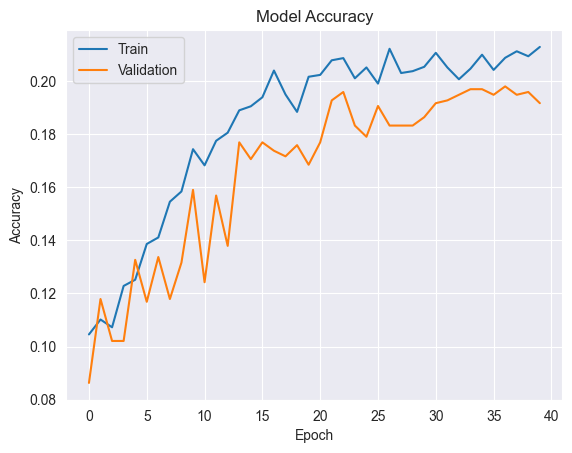

In [81]:
plt.plot(history_model_4.history['accuracy'])
plt.plot(history_model_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [111]:
model_4_evaluation = model_4.evaluate(X_val, (y_val))
print(model_4_evaluation)

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.1711 - loss: 2.3825
[2.357357978820801, 0.1768421083688736]


In [112]:
y_pred_model_4_val = model_4.predict(X_val)

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step


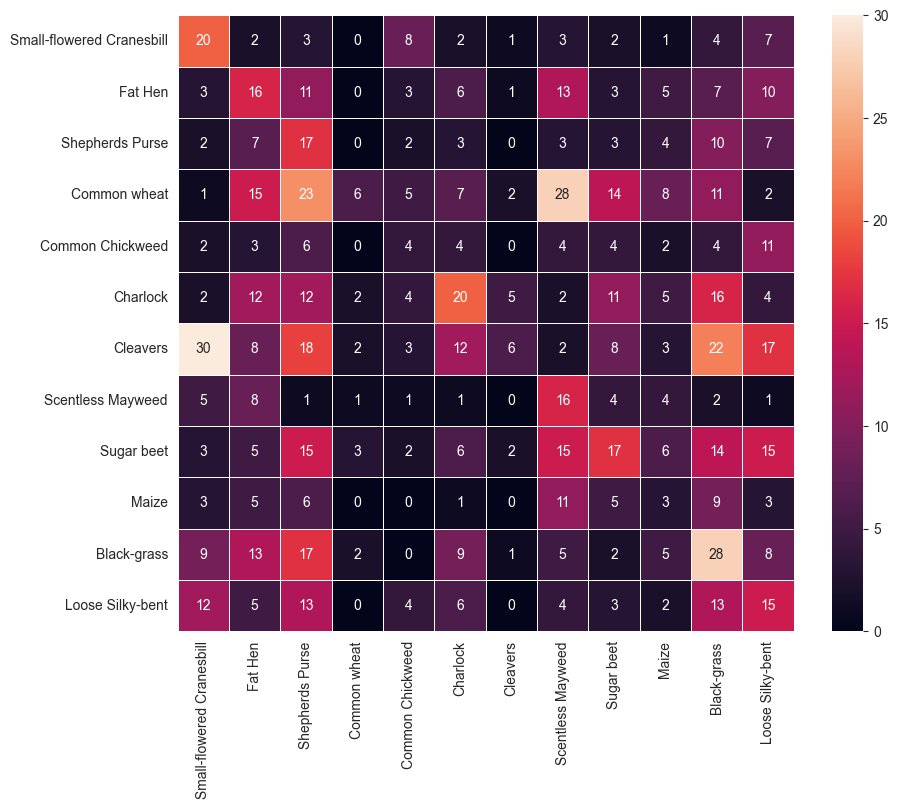

In [84]:
plot_confusion_matrix(y_pred_model_4_val, y_val, labels_list)

In [85]:
print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_model_4_val, axis=1), target_names=labels_list))

                           precision    recall  f1-score   support

Small-flowered Cranesbill       0.22      0.38      0.28        53
                  Fat Hen       0.16      0.21      0.18        78
          Shepherds Purse       0.12      0.29      0.17        58
             Common wheat       0.38      0.05      0.09       122
         Common Chickweed       0.11      0.09      0.10        44
                 Charlock       0.26      0.21      0.23        95
                 Cleavers       0.33      0.05      0.08       131
        Scentless Mayweed       0.15      0.36      0.21        44
               Sugar beet       0.22      0.17      0.19       103
                    Maize       0.06      0.07      0.06        46
              Black-grass       0.20      0.28      0.23        99
         Loose Silky-bent       0.15      0.19      0.17        77

                 accuracy                           0.18       950
                macro avg       0.20      0.20      0.17    

## Final Model
Comment on the final model you have selected and use the same in the below code to visualize the image.

### Model Summaries

In [113]:
models = [model_0, model_1, model_2, model_3, model_4]
results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy'])
results.loc[0, 'Model'] = 'Model 0'
results.loc[1, 'Model'] = 'Model 1'
results.loc[2, 'Model'] = 'Model 2 transfer learning VGG16'
results.loc[3, 'Model'] = 'Model 3'
results.loc[4, 'Model'] = 'Model 4 transfer learning ResNet101'

for idx, item in enumerate(models):
    train = item.evaluate(X_train, y_train)
    val = item.evaluate(X_val, y_val)
    results.loc[idx, 'Train Accuracy'] = train[1]
    results.loc[idx, 'Validation Accuracy'] = val[1]

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0022
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7072 - loss: 1.6757
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0016
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8436 - loss: 0.8569
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 247ms/step - accuracy: 0.8679 - loss: 0.3521
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.6000 - loss: 1.7613
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9990 - loss: 0.0064
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8773 - loss: 0.7773
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.1953 - loss: 2.2560
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.1711 - loss: 2.3825


In [87]:
results['Train Accuracy'] = results['Train Accuracy']*100
results['Validation Accuracy'] = results['Validation Accuracy']*100

In [88]:
results.style.set_caption("Models summaries result in %").hide_index().format(precision=3).format_index(str.upper, axis=1)

### Selected Model
As the table above:
* Model 0 a simple reference model without augmentation, is overfitting
* Model 1 is Model 0 with image augmentation, show a significant improvement but still overfitting (the accuracy difference between the training set and the validation set is still important)
* Model 3 has less difference between the training set and the validation set, it makes the most generalized model

Below, the result are show for each category for each of the Training, Validation and Test data set, as well as the confusion matrix.

The image augmentation (zoom, flip, rotate and contrast) used for the training set has helped. The strategy used has generated 3 augmented images for each training set image. 

In [89]:
final_model = model_3

In [114]:
y_pred_model_f_train = final_model.predict(X_train)
y_pred_model_f_val = final_model.predict(X_val)
y_pred_model_f_test = final_model.predict(X_test)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [91]:
model_final_train_report =  classification_report(np.argmax(y_train, axis=1), np.argmax(y_pred_model_f_train, axis=1),target_names=labels_list,output_dict=True)
model_final_val_report = classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_model_f_val, axis=1), target_names=labels_list,output_dict=True)
model_final_test_report =  classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_model_f_test, axis=1),target_names=labels_list,output_dict=True)

In [92]:
df_train = pd.DataFrame(model_final_train_report).transpose()
df_val = pd.DataFrame(model_final_val_report).transpose()
df_test = pd.DataFrame(model_final_test_report).transpose()

In [93]:
df = df_test.rename(columns={'precision':'precision test set'})
df['precision val set'] = df_val['precision']
df['precision train set'] = df_train['precision']
df.drop(['support','recall', 'f1-score'], axis=1, inplace=True)
df.drop(['macro avg','weighted avg'], axis=0, inplace=True)


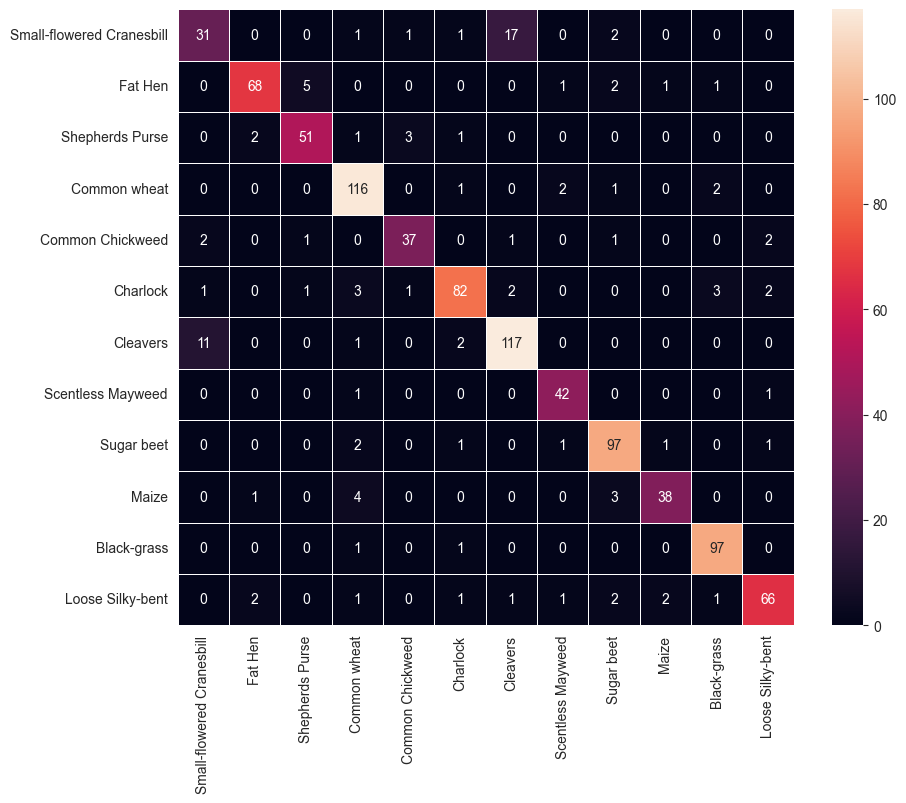

In [94]:
plot_confusion_matrix(y_pred_model_f_test, y_test, labels_list)

In [95]:
df.style.highlight_max(color = 'darkgreen', axis = 1, subset =['precision val set', 'precision test set']).format_index(str.upper, axis=1)

### Observation
The model3 applied on the test set gives good result, only 2 categories show a significant difference (21% and 10%), the model3 seems to be the best generalized model.

Models summaries result show the Model 3 is most generalized model giving good accuracy on the Validation set and good accuracy on the Test set. The accuracy difference is 0.00105 (more precisely 0.1%). Which make the model 3 the generalized model.

Above, the result are show for each category for each of the Training, Validation and Test data set, as well as the confusion matrix. 
Below, is the difference in % between the validation and test set for each category.

The image augmentation implemented that modify the original image 


In [96]:
diff = (abs(df['precision val set'] - df['precision test set']))*100 

In [115]:
diff.sort_values(ascending=False)

Small-flowered Cranesbill    21.950113
Shepherds Purse              10.145889
Scentless Mayweed             6.382979
Cleavers                      5.909369
Common wheat                  5.712677
Maize                         4.978355
Sugar beet                    4.359942
Charlock                      4.343434
Loose Silky-bent              3.861789
Black-grass                   3.637986
Fat Hen                       2.674494
Common Chickweed              1.904762
accuracy                      0.105263
dtype: float64

In [98]:
diff['accuracy']

0.10526315789473051

### Visualizing the prediction

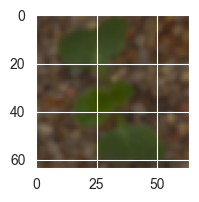

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted Label ['Charlock']
True Label Charlock


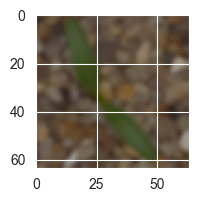

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted Label ['Sugar beet']
True Label Sugar beet


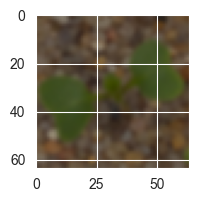

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted Label ['Charlock']
True Label Charlock


In [99]:
# Visualizing the predicted and correct label of images from test data
from sklearn import preprocessing
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(final_model.predict((X_test[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[2])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(final_model.predict((X_test[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[33])                                             # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(final_model.predict((X_test[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test)[36])

## Actionable Insights and Business Recommendations

* we need more dataset for the weak predicted category
* we could increase the size of the image to imporve the model
* as the selected model as a very fast execution, an increase of the size of the image will be beneficial without a major impact on the time for the evaluation and on the memory size.
* Data augmentation has helped a lot the result
* this notebook uses the latest Tensorflow API 2.16 (the tf.keras.preprocessing is now deprecated and tf.keras.preprocessing.image.ImageDataGenerator is part of the module). This notebook uses an alternative for the image augmentation, this is suitable for large dataset and provides more control on the image transformation.

# Annex


In [100]:

def add_new_element_at_index(image_array, image, index):
    '''
    Insert a augmented image into the image array at the specified index
    :param an array of images: 
    :param image: the new image to insert in the array
    :param index: the index at which will insrt the index
    :return: the new image array
    '''
    # Create a new image array with one extra row
    new_array = np.empty((image_array.shape[0] + 1, image_array.shape[1]))

    # Copy the elements from the original image array to the new array, inserting the image at the specified index
    new_array[np.r_[:index, index + 1:]] = image_array
    new_array[index] = image
    return new_array

In [101]:

def augment_image2(image):
    '''
    Apply random transformations to the image
    :param image: 
    :return: the augmented image
    '''
    # Geometric transformations
    if random.random() < 0.5:
        image = cv2.flip(image, 1)  # Horizontal flip

    if random.random() < 0.5:
        angle = random.randint(-30, 30)  # Rotation
        M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    if random.random() < 0.5:
        scale_factor = random.uniform(0.8, 1.2)  # Scaling
        image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

    # Color transformations
    if random.random() < 0.5:
        brightness_factor = random.uniform(0.5, 1.5)  # Brightness adjustment
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    if random.random() < 0.5:
        contrast_factor = random.uniform(0.5, 1.5)  # Contrast adjustment
        image = np.clip(image * contrast_factor + (1 - contrast_factor) * 128, 0, 255).astype(np.uint8)

    return image

In [102]:
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.15.0


_____